In [6]:
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plot_fairness_metrics import *

In [7]:
def compute_individual_weights(df, label_col, protected_attr_col):
    """
    Compute weights for a single protected attribute to rebalance joint label/protected group distribution.
    """
    joint_counts = df.groupby([protected_attr_col, label_col]).size().reset_index(name='joint_count')
    attr_counts = df[protected_attr_col].value_counts(normalize=True).reset_index()
    attr_counts.columns = [protected_attr_col, 'attr_prob']
    label_counts = df[label_col].value_counts(normalize=True).reset_index()
    label_counts.columns = [label_col, 'label_prob']

    weights_df = joint_counts.merge(attr_counts, on=protected_attr_col)
    weights_df = weights_df.merge(label_counts, on=label_col)

    weights_df['weight'] = weights_df['attr_prob'] * weights_df['label_prob'] / (weights_df['joint_count'] / len(df))

    return weights_df[[protected_attr_col, label_col, 'weight']]

def compute_combined_weights(df, label_col, protected_attrs):
    """
    Compute instance weights by multiplying individual fairness weights across multiple protected attributes.
    """
    df = df.copy()
    df['weight'] = 1.0  # Start with neutral weights

    for attr in protected_attrs:
        w = compute_individual_weights(df, label_col, attr)
        w = w.rename(columns={'weight': f'weight_{attr}'})
        df = df.merge(w, on=[attr, label_col], how='left')
        df['weight'] *= df[f'weight_{attr}']

    return df


In [8]:
from sklearn.preprocessing import QuantileTransformer

def remove_disparate_impact_global(df, features, protected_attr, repair_level=0.5):
    df = df.copy()
    
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan

        # Global reference distribution
        qt_global = QuantileTransformer(output_distribution='normal')
        global_transformed = qt_global.fit_transform(df[[feature]]).flatten()

        df[f"{feature}_quantile"] = global_transformed  # for interpolation

        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            original = df.loc[group_mask, feature]
            transformed = df.loc[group_mask, f"{feature}_quantile"]
            repaired = (1 - repair_level) * original + repair_level * transformed
            df.loc[group_mask, repaired_col] = repaired

        df.drop(columns=[f"{feature}_quantile"], inplace=True)

    return df


In [9]:
from sklearn.preprocessing import QuantileTransformer
import pandas as pd
import numpy as np

def remove_disparate_impact(df, features, protected_attr, repair_level=1.0):

    df = df.copy()
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan
        
        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            group_values = df.loc[group_mask, feature].values.reshape(-1, 1)
            
            qt = QuantileTransformer(output_distribution='normal')
            transformed = qt.fit_transform(group_values).flatten()
            
            original = df.loc[group_mask, feature]
            repaired = (1 - repair_level) * original + repair_level * transformed
            
            df.loc[group_mask, repaired_col] = repaired

    return df


In [10]:
df = pd.read_csv('peranna2.csv')
df_copied = df.copy()
predicted_cols = ['pass_bar_lr', 'pass_bar_lr_weighted',
       'pass_bar_lr_best', 'pass_bar_rf', 'pass_bar_xgb', 'pass_bar_xgb_r']
df.drop(columns=predicted_cols, inplace=True)

In [11]:
race_enc = LabelEncoder()
df['race1_encoded'] = race_enc.fit_transform(df['race1'])

In [12]:
race_mapping = dict(zip(race_enc.classes_, race_enc.transform(race_enc.classes_)))
print(race_mapping)

{'asian': 0, 'black': 1, 'hisp': 2, 'other': 3, 'white': 4}


In [13]:
nokeep = ['bar', 'race2', 'race1']
keep = list(set(df.columns) - set(nokeep))
df = df[keep]

In [14]:
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'race1_encoded']

target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [15]:
df_train = X_train.copy()
df_train[target] = y_train
df_test = X_test.copy()
df_test[target] = y_test

In [16]:
new_features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'race1_encoded_repaired', 'tier_repaired', 'fam_inc_repaired']

In [17]:
df_train_rw = df_train.copy()
df_train_rw['race1_encoded_repaired'] = remove_disparate_impact(df_train, ['race1_encoded'], 'race1_encoded')['race1_encoded_repaired']
df_train_rw['tier_repaired'] = remove_disparate_impact(df_train, ['tier'], 'tier')['tier_repaired']
df_train_rw['fam_inc_repaired'] = remove_disparate_impact(df_train, ['fam_inc'], 'fam_inc')['fam_inc_repaired']

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (814). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (711). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (324). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (475). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local

In [18]:
protected_features = ['race1_encoded', 'tier', 'fam_inc']
df_train_rw = compute_combined_weights(df_train_rw, label_col='pass_bar', protected_attrs=protected_features)

In [19]:
X_train_rw = df_train_rw[new_features]
y_train_rw = df_train_rw[target]

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

param_grid = {
    'C': [0.01, 0.1, 1, 10], #normalization
    'class_weight': [{0: w0, 1: 1} for w0 in [5, 10, 20, 50, 100]] # we try penalizing more only class 0 mistakes
}

lr = LogisticRegression(max_iter=1000, solver='liblinear') 


fbeta_scorer = make_scorer(fbeta_score, beta=2, pos_label=0)
                               
grid_search = GridSearchCV(lr, param_grid, scoring=fbeta_scorer, cv=5, n_jobs=-1)

grid_search.fit(X_train_rw, y_train_rw, sample_weight=df_train_rw['weight'])

lr_best_model = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)
print("Best Fbeta-score for class 0:", grid_search.best_score_)

Best parameters: {'C': 10, 'class_weight': {0: 10, 1: 1}}
Best Fbeta-score for class 0: 0.4459437278120813


In [21]:
# from sklearn.metrics import confusion_matrix, classification_report


# y_test_pred = lr_best_model.predict(X_test)

# print(confusion_matrix(y_test, y_test_pred))
# print(classification_report(y_test, y_test_pred))

### on whole dataset

In [22]:
df_rw = df.copy()
df_rw['race1_encoded_repaired'] = remove_disparate_impact(df, ['race1_encoded'], 'race1_encoded')['race1_encoded_repaired']
df_rw['tier_repaired'] = remove_disparate_impact(df, features=['tier'], protected_attr='tier', repair_level=1.0)['tier_repaired']
df_rw['fam_inc_repaired'] = remove_disparate_impact(df, features=['fam_inc'], protected_attr='fam_inc', repair_level=1.0)['fam_inc_repaired']

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (888). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (404). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (582). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (452). n_quantiles is set to n_samples.
  warnings.warn(


In [23]:
df_rw

,zgpa,ugpa,zfygpa,pass_bar_mlp_best,decile1,ID,race1_other,Unnamed: 0,bar2,bar2_yr,...,race1_hisp,bar1,race1_black,fam_inc,decile3,male,race1_white,race1_encoded_repaired,tier_repaired,fam_inc_repaired
0,1.88,3.5,1.33,1,10.0,2,False,0,1,94.0,...,False,1,False,5.0,10.0,0.0,True,-5.199338,-5.199338,-5.199338
1,-0.57,3.5,-0.11,1,5.0,3,False,1,1,94.0,...,False,1,False,4.0,4.0,0.0,True,-5.199338,-5.199338,-5.199338
2,-1.12,3.5,-0.64,0,3.0,36,False,2,1,94.0,...,False,1,False,1.0,2.0,1.0,True,-5.199338,-5.199338,-5.199338
3,-0.49,3.5,0.34,1,7.0,52,False,3,1,94.0,...,False,1,False,4.0,4.0,1.0,True,-5.199338,-5.199338,-5.199338
4,0.76,3.5,1.02,1,9.0,55,False,4,1,94.0,...,False,1,False,4.0,8.0,1.0,True,-5.199338,-5.199338,-5.199338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,-1.49,1.8,-0.58,0,3.0,10695,False,22402,0,95.0,...,False,0,True,2.0,1.0,1.0,False,-5.199338,-5.199338,-5.199338
22068,-1.36,1.8,-0.64,0,3.0,19642,False,22403,0,94.0,...,False,0,True,3.0,1.0,1.0,False,-5.199338,-5.199338,-5.199338
22069,0.80,1.8,0.41,1,7.0,24704,False,22404,1,95.0,...,False,1,True,3.0,8.0,1.0,False,-5.199338,-5.199338,-5.199338
22070,1.42,1.5,1.88,1,10.0,10000,False,22405,1,95.0,...,False,1,False,3.0,10.0,1.0,True,-5.199338,-5.199338,-5.199338


In [24]:
pass_bar_lr_rw = lr_best_model.predict(df_rw[new_features])
df_rw['pass_bar_lr_rw'] = pass_bar_lr_rw

In [25]:
df_rw

,zgpa,ugpa,zfygpa,pass_bar_mlp_best,decile1,ID,race1_other,Unnamed: 0,bar2,bar2_yr,...,bar1,race1_black,fam_inc,decile3,male,race1_white,race1_encoded_repaired,tier_repaired,fam_inc_repaired,pass_bar_lr_rw
0,1.88,3.5,1.33,1,10.0,2,False,0,1,94.0,...,1,False,5.0,10.0,0.0,True,-5.199338,-5.199338,-5.199338,1
1,-0.57,3.5,-0.11,1,5.0,3,False,1,1,94.0,...,1,False,4.0,4.0,0.0,True,-5.199338,-5.199338,-5.199338,1
2,-1.12,3.5,-0.64,0,3.0,36,False,2,1,94.0,...,1,False,1.0,2.0,1.0,True,-5.199338,-5.199338,-5.199338,0
3,-0.49,3.5,0.34,1,7.0,52,False,3,1,94.0,...,1,False,4.0,4.0,1.0,True,-5.199338,-5.199338,-5.199338,1
4,0.76,3.5,1.02,1,9.0,55,False,4,1,94.0,...,1,False,4.0,8.0,1.0,True,-5.199338,-5.199338,-5.199338,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,-1.49,1.8,-0.58,0,3.0,10695,False,22402,0,95.0,...,0,True,2.0,1.0,1.0,False,-5.199338,-5.199338,-5.199338,0
22068,-1.36,1.8,-0.64,0,3.0,19642,False,22403,0,94.0,...,0,True,3.0,1.0,1.0,False,-5.199338,-5.199338,-5.199338,0
22069,0.80,1.8,0.41,1,7.0,24704,False,22404,1,95.0,...,1,True,3.0,8.0,1.0,False,-5.199338,-5.199338,-5.199338,1
22070,1.42,1.5,1.88,1,10.0,10000,False,22405,1,95.0,...,1,False,3.0,10.0,1.0,True,-5.199338,-5.199338,-5.199338,1


In [26]:
print(df_rw['race1_encoded_repaired'].describe())
print(df_rw['race1_encoded_repaired'].nunique())
print(df_rw['race1_encoded_repaired'].value_counts())

count    22072.000000
mean        -5.199338
std          0.000000
min         -5.199338
25%         -5.199338
50%         -5.199338
75%         -5.199338
max         -5.199338
Name: race1_encoded_repaired, dtype: float64
1
race1_encoded_repaired
-5.199338    22072
Name: count, dtype: int64


In [27]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd

def compute_disparate_impact_by_race(df, label_col='pass_bar', race_col='race1_encoded', white_label=4):
    results = []

    # Filter all unique race codes except White (reference group)
    race_codes = sorted(df[race_col].unique())
    other_races = [r for r in race_codes if r != white_label]

    for group in other_races:
        # Create dataset with only White and one comparison group
        df_pair = df[df[race_col].isin([white_label, group])].copy()
        df_pair[race_col + '_bin'] = df_pair[race_col].apply(lambda x: 1 if x == white_label else 0)

        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df_pair,
            label_names=[label_col],
            protected_attribute_names=[race_col + '_bin']
        )

        metric = BinaryLabelDatasetMetric(
            dataset,
            privileged_groups=[{race_col + '_bin': 1}],  # White
            unprivileged_groups=[{race_col + '_bin': 0}]  # Current group
        )

        di = metric.disparate_impact()

        results.append({
            'Group': f'{group} vs White',
            'Disparate Impact': di
        })

    return pd.DataFrame(results)

di_results = compute_disparate_impact_by_race(df_rw, label_col='pass_bar_lr_rw', race_col='race1_encoded', white_label=4)
print(di_results)

        Group  Disparate Impact
0  0 vs White          0.826740
1  1 vs White          0.440109
2  2 vs White          0.673803
3  3 vs White          0.770143


In [28]:
results_all = {}

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

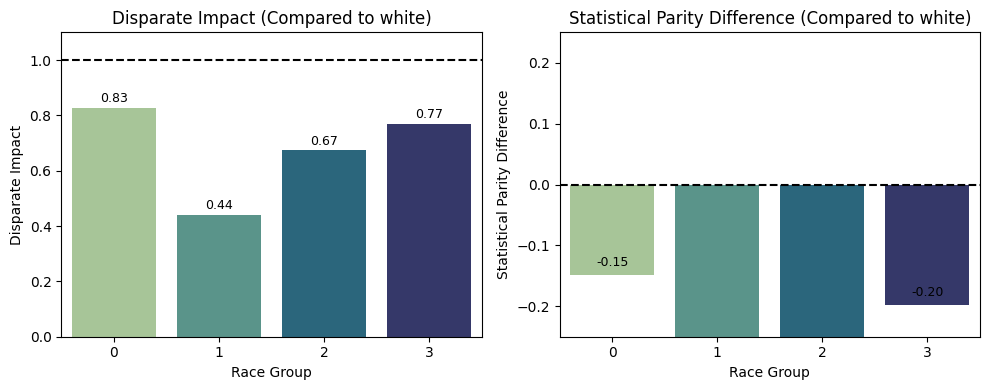

In [29]:
race_groups = [0, 1, 2, 3]
results = get_DI_SPD_WD(race_groups, df_rw, 'race1_encoded', 4, 'pass_bar_lr_rw')
plot_fairness_metrics(results, 'Race Group', 'white')
results_all['Race'] = results

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

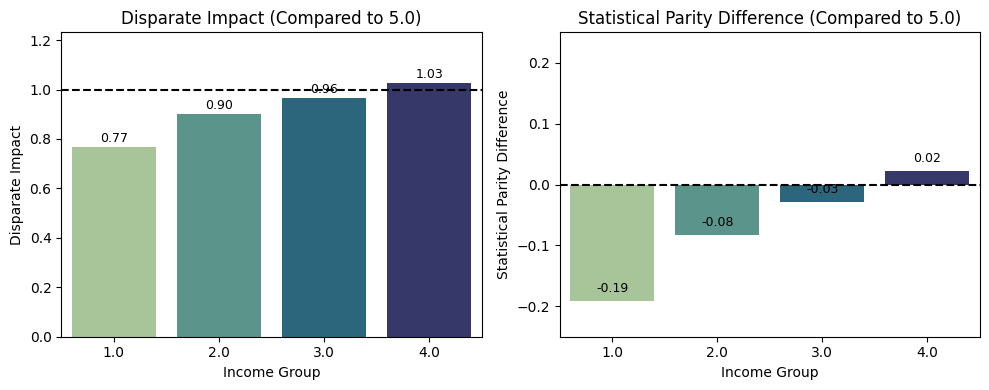

In [30]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df_rw, 'fam_inc', 5.0, 'pass_bar_lr_rw')
plot_fairness_metrics(results, 'Income Group', 5.0)
results_all['Family income'] = results

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

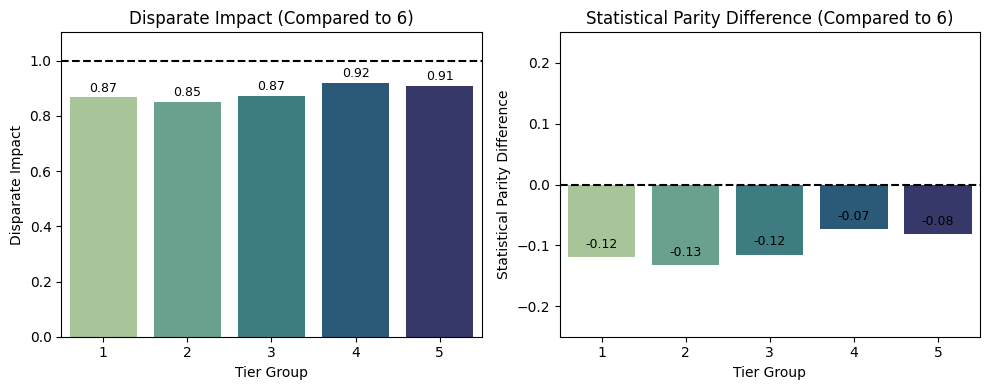

In [31]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df_rw, 'tier', 6, 'pass_bar_lr_rw')
plot_fairness_metrics(results, 'Tier Group', 6)
results_all['Tier'] = results

In [32]:
results_all

{'Race': {0: {'Disparate Impact': 0.8267399192413394,
   'Statistical Parity Difference': -0.14868158701437872},
  1: {'Disparate Impact': 0.44010928335206645,
   'Statistical Parity Difference': -0.4804652054952449},
  2: {'Disparate Impact': 0.6738027788766379,
   'Statistical Parity Difference': -0.27992322469166},
  3: {'Disparate Impact': 0.7701427309934175,
   'Statistical Parity Difference': -0.19724995736492723}},
 'Family income': {1.0: {'Disparate Impact': 0.76606697573662,
   'Statistical Parity Difference': -0.19186895040245233},
  2.0: {'Disparate Impact': 0.8991776056401927,
   'Statistical Parity Difference': -0.08269327104965996},
  3.0: {'Disparate Impact': 0.9647106564847971,
   'Statistical Parity Difference': -0.028943879650913718},
  4.0: {'Disparate Impact': 1.026242273689718,
   'Statistical Parity Difference': 0.021523585756542007}},
 'Tier': {1: {'Disparate Impact': 0.8667886227510785,
   'Statistical Parity Difference': -0.11935581052169342},
  2: {'Disparate 

## Method explanation
The method used is not textbook, but was necessary in order to reduce the bias in a way which made sense, as it was specifically hard to tackle in the preprocessing case. The textbook approaches didn't seem to work at all. The Disparate Impact Remover library from AIF360 is at the moment not working because of technical problems on their side, so I decided to implement a similar approach by hand. 

Disparate Impact is a metric which has a threshold of 1, and we generally enforce the 80% rule, meaning that if the values drop below 80% the feature is considered unacceptably biased. DIR is a preprocessing fairness technique which transforms the feature distributions so that protected group membership can no longer be easily inferred. So it alters the ability of the features to be proxies for group identities. More easily, we are hiding where a specific individual belongs to. Another added challenge in this instance was tackling three different features at the same time. It was also proven that using the disparate impact remover on one feature at a time produced worse overall results (80% rule was not respected).

In this second try, I am not using the inovative approach from before, and I am adopting something which is much more standard. This does not artificially remove the bias by using both the individual and global disparate impact remover, but it adds the custom weights to the training part, computing weights for a single protected attribute to rebalance joint label/protected group distribution, as well as individual weights. This aims to give weights to the protected features so that the model does not overly rely on those to make predictions, both in an individual and group way to avoid learning from bias as much as possible. 

This is a very standard technique, but it is evident that the results are not as satisfactory as we saw with the previous method. For the Family Income and Tier features, actually, the results all respect the 80% rule, which indicates that the bias has been removed, while for the Race feature the situation is a lot more challenging. A reason behind this could be that the representation bias is harsher in this case, meaning that the number of white people in the database is much greater than all the other instances combined. This makes it much harder to remove the bias.  

